In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

## Custom Component Requirements
#### Build a Custom Component


In [3]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

#### Run the Component

In [4]:
greeter = Greeter()

greeter.run(user_name="Tuana")

{'greeting': 'Hello Tuana'}

#### Add the Component to a Pipeline

In [5]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

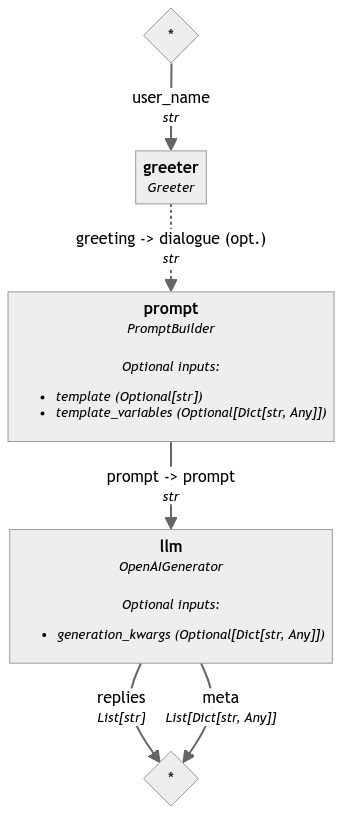

In [6]:
dialogue_builder.show()

In [7]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

Characters:
- Sarah
- Tuana

(Scene opens with Sarah entering a cafe where Tuana is sitting at a table, lost in thought)

Sarah: (approaching Tuana) Hello Tuana.

Tuana: (startled) Oh, hello Sarah. I didn't see you there.

Sarah: Mind if I join you?

Tuana: Of course not, please, sit down.

(Sarah takes a seat across from Tuana)

Sarah: Is everything alright? You seem lost in thought.

Tuana: Oh, it's nothing, just some personal stuff going on.

Sarah: Well, if you need to talk about it, I'm here to listen.

Tuana: Thank you, Sarah. It's just been a rough few days. I feel like I'm at a crossroads in my life and I don't know which path to take.

Sarah: I know how that feels. Sometimes, it's best to just take a step back and really think about what you want.

Tuana: I've been trying to do that, but it's so hard to see clearly when you're in the midst of it all.

Sarah: (placing a hand on Tuana's) You'll figure it out, Tuana. You're strong and smart. Just trust yourself.

Tuana: Thank you

## Build a Hacker News Summarizer

> **Note:** Everyone will get different results for this application to what you see in the recording. Results depend on when you run it as it's based on 'current' top/new posts on Hacker News. 

In [8]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'todsacerdoti', 'descendants': 1, 'id': 41318000, 'kids': [41318341], 'score': 52, 'time': 1724315243, 'title': 'SwiftUI for Mac 2024', 'type': 'story', 'url': 'https://troz.net/post/2024/swiftui-mac-2024/'}


In [9]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [10]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [11]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=9f39b2094aec783286aa627b58b66abd5484bc36c3e72a5b87695d0605161ca9, content: 'SwiftUI for Mac 2024
Over the years, I have written articles and sample apps to demonstrate the new ...', meta: {'content_type': 'text/html', 'url': 'https://troz.net/post/2024/swiftui-mac-2024/'}), Document(id=4b76e8047d64b7114a3eb06c74fb3f66455d22ebb00dd2687f58c4c30332ae16, content: 'Self-hostable clone of lazydocker for the web.
Manage your Docker fleet with ease
Table of Contents ...', meta: {'content_type': 'text/html', 'url': 'https://github.com/will-moss/isaiah'}), Document(id=daecd71da6cc2f1174fb68d448612cd45dd76baaecd98015653bdb2442eab98a, content: 'I decided to leave what had been a promising career in organic chemistry about a year ago. Deciding ...', meta: {'content_type': 'text/html', 'url': 'https://franceshocutt.com/2014/09/10/on-mourning-and-moving-on-rituals-for-leaving-a-career/'})]


In [12]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [13]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

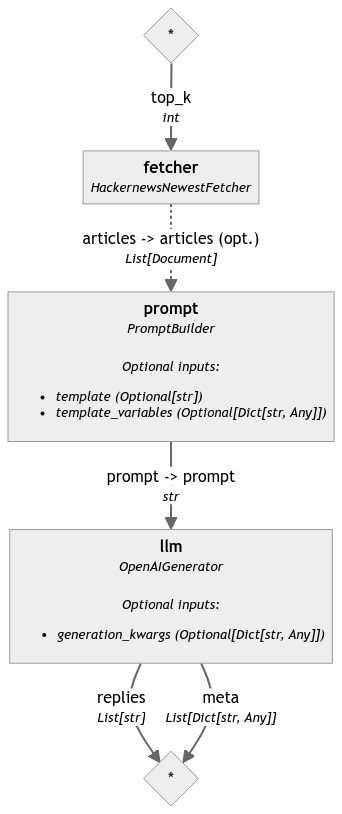

In [14]:
summarizer_pipeline.show()

In [15]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

The post describes a personal journey of leaving a career in organic chemistry and the challenges faced in making that decision. The author invites friends to a "wake" to mourn the loss of the research science career and celebrate the good things taken from it while looking forward to the future. The "wake" involves sharing food, drink, stories, and rituals to mark the transition and seek support from the community. The post reflects on the challenges of leaving a traditional career path and the importance of acknowledging and processing the decision.


In [16]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [17]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

1. SwiftUI for Mac 2024
Summary: An in-depth look at the latest features in SwiftUI for Mac in 2024, covering Xcode updates, predictive code completion, new file creation options, previews, window management, tabs, charts, colors, SF Symbols animations, and more.
URL: https://troz.net/post/2024/swiftui-mac-2024/

2. Self-hostable clone of lazydocker for the web
Summary: Isaiah is a self-hostable service that allows for the management of Docker resources on a remote server via a web interface. Features include managing stacks, containers, images, volumes, networks, and more in a user-friendly manner.
URL: https://github.com/will-moss/isaiah


### Extra resources! 

Learn more about the Haystack integrations:

* [deepset-ai github repo](https://github.com/deepset-ai/haystack-integrations)
* [haystack.deepset.ai/integrations](https://haystack.deepset.ai/integrations)